<a href="https://colab.research.google.com/github/jmakings/exTreg-Analysis/blob/main/JS_Antoine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path

# **Antoine's V and V-J genes Jensen-Shannon Analysis**

In [ ]:
# load in all the v genes and vj Genes content
vj4 = pd.read_csv('/content/drive/MyDrive/Freq_V-J_Combined_Donor4.csv')
vj5 = pd.read_csv('/content/drive/MyDrive/Freq_V-J_Combined_Donor5.csv')
vj6 = pd.read_csv('/content/drive/MyDrive/Freq_V-J_Combined_Donor6.csv')
vj7 = pd.read_csv('/content/drive/MyDrive/Freq_V-J_Combined_Donor7.csv')
v4 = pd.read_csv('/content/drive/MyDrive/Freq_v_resolved_Donor4.csv')
v5 = pd.read_csv('/content/drive/MyDrive/Freq_v_resolved_Donor5.csv')
v6 = pd.read_csv('/content/drive/MyDrive/Freq_v_resolved_Donor6.csv')
v7 = pd.read_csv('/content/drive/MyDrive/Freq_v_resolved_Donor7.csv')

In [ ]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', None)

# **Functions for Pipeline**

In [ ]:
# takes pandas dataframe as input, outputs the two probability distributions
def get_distributions(data, col1,col2):
  data = data[data[col1].notna()]
  data = data[data[col2].notna()]
  
  c1 = list(data[col1])
  c2 = list(data[col2])
  if len(c1) != len(c2):
    print("Error: Unequal length distributions")
    return
  return c1,c2

In [ ]:
# computes JS distance and normalizes it by mean Shannon Entropy between two distributions
def js_distance(c1,c2):
  dis = distance.jensenshannon(c1,c2, 2, axis=0)
  ent1 = scipy.stats.entropy(c1,base=2)
  ent2 = scipy.stats.entropy(c2,base=2)
  normalized = dis/((ent1+ent2)/2)
  return normalized

In [ ]:
# computes JS divergence and normalizes it by mean Shannon Entropy between two distributions
def js_divergence(c1,c2):
    dis = np.square(distance.jensenshannon(c1,c2, 2, axis=0))
    ent1 = scipy.stats.entropy(c1,base=2)
    ent2 = scipy.stats.entropy(c2,base=2)
    normalized = dis/((ent1+ent2)/2)
    return normalized

In [ ]:
# given Pandas dataframe and two columns (distributions) to compare,
# computes the Jensen-Shannon DISTANCE between them and divides by mean Shannon Entropy
# of the two distributions
def jsDistance_Pipeline(data,col1,col2):
    c1,c2 = get_distributions(data,col1,col2)
    return js_distance(c1,c2)

In [ ]:
# given Pandas dataframe and two columns (distributions) to compare,
# computes the Jensen-Shannon DIVERGENCE between them and divides by mean Shannon Entropy
# of the two distributions
def jsDivergence_Pipeline(data,col1,col2):
    c1,c2 = get_distributions(data,col1,col2)
    return js_divergence(c1,c2)

# **Preprocessing the dataframes**

In [ ]:
def dropNAs(df): 
  df = df.dropna(axis=0,how='all')
  df = df.dropna(axis=1,how='all')
  return df

In [ ]:
# merges 4 dataframes together with outer join, fills NAs with 0
def mergeFrames(df1,df2,df3,df4, definer):
  df1 = dropNAs(df1)
  df2 = dropNAs(df2)
  df3 = dropNAs(df3)
  df4 = dropNAs(df4)
  
  DF = df1.merge(df2,left_on=definer, right_on=definer, how='outer')
  DF = DF.merge(df3,left_on=definer, right_on=definer, how='outer') 
  DF = DF.merge(df4,left_on=definer, right_on=definer, how='outer')
  DF = DF.fillna(0)
  return DF    

In [ ]:
# sums the same cell types and creates frequency distributions for each
def combined_frequencies(df):
  for i in range(4):
    v = df.columns[i+1]
    name = v[:-2] + '_CombinedCounts'
    df[name] = df.iloc[:,i+1] + df.iloc[:,i+5] + df.iloc[:,i+9] + df.iloc[:,i+13]
    combSum = df[name].sum()
    name2 = v[:-2] + "_frequencies"
    df[name2] = df[name] / combSum
  return df

In [ ]:
# from individual donor dataframes, gives combined dataframe with frequency distributions
def createFrequencyDF(df1,df2,df3,df4, definer):
  DF = mergeFrames(df1,df2,df3,df4, definer)
  DF = combined_frequencies(DF)
  return DF

In [ ]:
vGenes = createFrequencyDF(v4,v5,v6,v7, 'v_resolved')

In [ ]:
# check that all of the unique TCR V genes are used
len(set(pd.concat([v4['v_resolved'], v5['v_resolved'], v6['v_resolved'], v7['v_resolved'] ]))) == len(vGenes['v_resolved'])

True

# **V Genes**

In [ ]:
# abbreviations
th1 = 'Th1_frequencies'
tn = 'Tn_frequencies'
treg = 'Tregs_frequencies'
extreg = 'exTregs_frequencies'
types = [th1,tn,treg,extreg]

In [ ]:
def compareTypes(df, typeList):
  distances = pd.DataFrame()
  divergences = pd.DataFrame()
  for i in range(len(typeList)):
    for j in range(len(typeList)):
      #print(str(i) + "_" + str(j))
      type1 = typeList[i][:-12]
      type2 = typeList[j][:-12]
      
      dis = jsDistance_Pipeline(df, typeList[i],typeList[j])
      div = jsDivergence_Pipeline(df, typeList[i], typeList[j])

      addDis = {"Row": type1, "Column": type2, "JS_Distance": dis}
      addDiv = {"Row": type1, "Column": type2, "JS_Divergence": div}

      distances = distances.append(addDis, ignore_index=True)
      divergences = divergences.append(addDiv, ignore_index=True)
      
  return distances, divergences

In [ ]:
vdistances, _ = compareTypes(vGenes, types)

In [ ]:
vdistances2 = vdistances.pivot("Row", "Column", "JS_Distance")

Text(0.5, 1.0, 'Jensen-Shannon Distance between V-genes of\nT-Cell Types for all Donors')

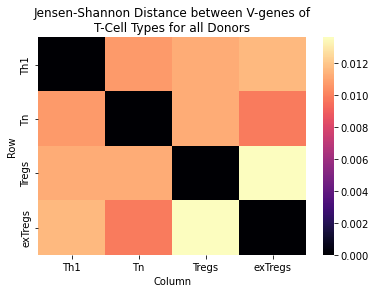

In [ ]:
ax = plt.axes()
sns.heatmap(vdistances2, ax=ax, cmap='magma')
ax.set_title("Jensen-Shannon Distance between V-genes of\nT-Cell Types for all Donors")

# **V-J Genes**

In [ ]:
vjGenes = createFrequencyDF(vj4,vj5,vj6,vj7, "V-J_Combined")

In [ ]:
vjGenes

Text(0.5, 1.0, 'Jensen-Shannon Distance between VJ-Genes\nof T-Cell Types for all Donors')

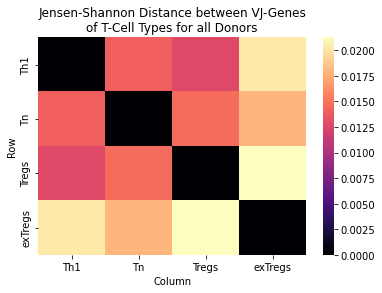

In [ ]:
vjDistance, _ = compareTypes(vjGenes, types )
vjDistance = vjDistance.pivot("Row", "Column", "JS_Distance")
ax = plt.axes()
sns.heatmap(vjDistance, ax=ax, cmap='magma')
ax.set_title("Jensen-Shannon Distance between VJ-Genes\nof T-Cell Types for all Donors")
#plt.figure(figsize=(80,60), dpi=400)

# **Write to file**

In [ ]:
vdistances2

Column,Th1,Tn,Tregs,exTregs
Row,,,,
Th1,0.000000,0.010688,0.011213,0.011580
Tn,0.010688,0.000000,0.011244,0.009856
Tregs,0.011213,0.011244,0.000000,0.013582
exTregs,0.011580,0.009856,0.013582,0.000000


In [ ]:
vjDistance

Column,Th1,Tn,Tregs,exTregs
Row,,,,
Th1,0.000000,0.014107,0.012719,0.020293
Tn,0.014107,0.000000,0.014771,0.017973
Tregs,0.012719,0.014771,0.000000,0.021261
exTregs,0.020293,0.017973,0.021261,0.000000


In [ ]:
vdistances2.to_csv("v_gene_distances.csv")
vjDistance.to_csv('vj_gene_distances.csv')

In [ ]:
!cp v_gene_distances.csv '/content/drive/MyDrive'
!cp vj_gene_distances.csv '/content/drive/MyDrive'

# **Get distance for all donors**

In [ ]:
vGenes

In [ ]:
vjGenes

In [ ]:
def donorFrequencies(df):
  for i,j in enumerate(df.columns):
    if i > 0 and i < 17:
      colsum = df[j].sum()
      name = j + '_freqs'
      df[name] = df[j]/colsum

  return df

In [ ]:
def compareDonors(df):
  distances = pd.DataFrame()
  for i in df.columns[25:]: 
    for j in df.columns[25:]:
      type1 = i[:-6]
      type2 = j[:-6]

      dis = jsDistance_Pipeline(df, i, j)

      addDis = {"Row": type1, "Column": type2, "JS_Distance": dis}

      distances = distances.append(addDis, ignore_index=True)
  
  return distances

In [ ]:
# from dataframe created for pooled cell type comparison, this will create a dataframe for individual donor comparison 
def donorPipeline(df):
  df = donorFrequencies(df)
  return compareDonors(df)

Text(0.5, 1.0, 'Jensen-Shannon Distance between V-Genes\nfor each Donor/Cell Type combination')

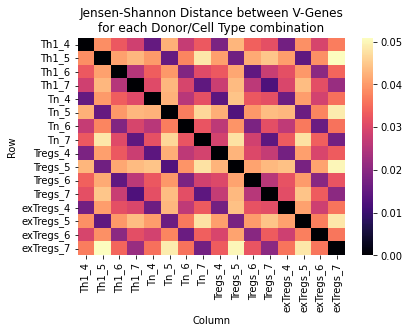

In [ ]:
vDonorDistance = donorPipeline(vGenes)
vDonorDistance = vDonorDistance.pivot("Row", "Column", "JS_Distance")
ax = plt.axes()
sns.heatmap(vDonorDistance, ax=ax, cmap='magma')
ax.set_title("Jensen-Shannon Distance between V-Genes\nfor each Donor/Cell Type combination")

In [ ]:
vDonorDistance.to_csv("v_Donor_distances.csv")
vjDonorDistance.to_csv('vj_gene_distances.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


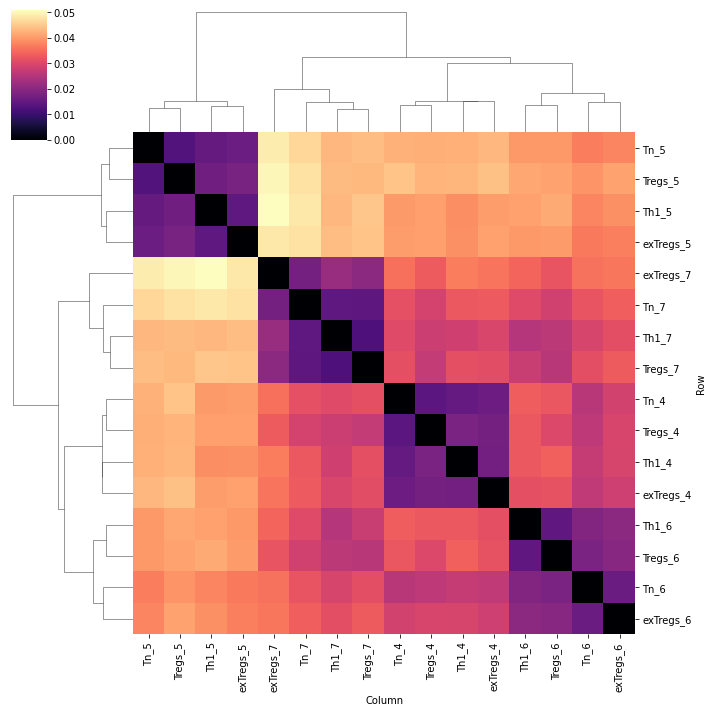

In [ ]:
vDonorDistance = donorPipeline(vGenes)
vDonorDistance = vDonorDistance.pivot("Row", "Column", "JS_Distance")
sns.clustermap(vDonorDistance, cmap='magma')
#ax.set_title("Jensen-Shannon Distance between V-Genes\nfor each Donor/Cell Type combination")

Text(0.5, 1.0, 'Jensen-Shannon Distance between VJ-Genes\nfor each Donor/Cell Type combination')

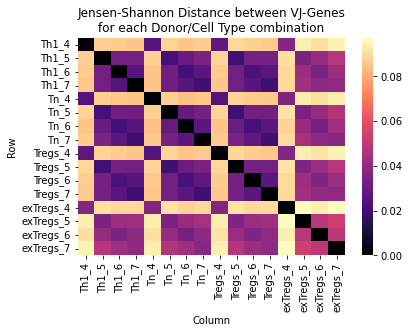

In [ ]:
vjDonorDistance = donorPipeline(vjGenes)
vjDonorDistance = vjDonorDistance.pivot("Row", "Column", "JS_Distance")
ax = plt.axes()
sns.heatmap(vjDonorDistance, ax=ax, cmap='magma')
ax.set_title("Jensen-Shannon Distance between VJ-Genes\nfor each Donor/Cell Type combination")

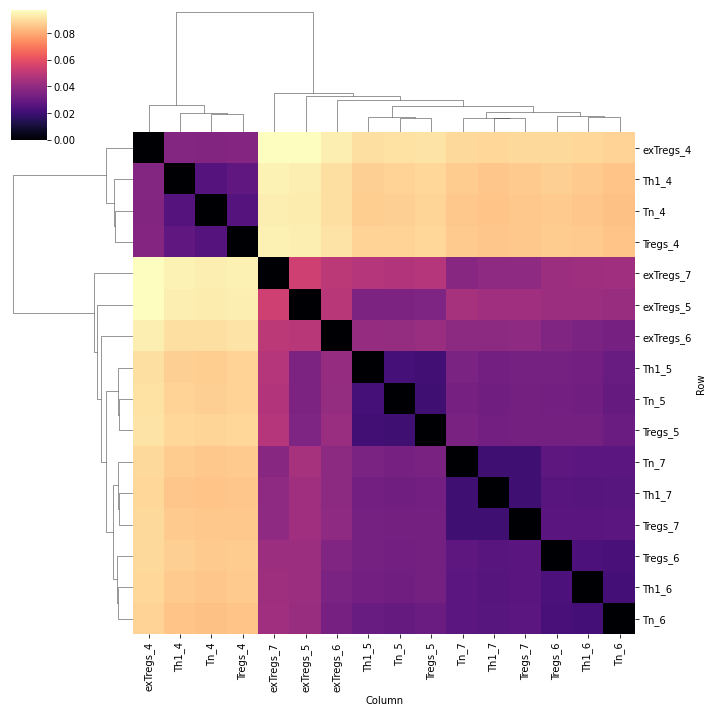

In [ ]:
vjDonorDistance = donorPipeline(vjGenes)
vjDonorDistance = vjDonorDistance.pivot("Row", "Column", "JS_Distance")
sns.clustermap(vjDonorDistance, cmap='magma')

# **Subset for Comparisons within Each Donor**

In [ ]:
vGene4 = vDonorDistance[['Th1_4', 'Tn_4', 'Tregs_4','exTregs_4']] 


In [ ]:
vGene4 = vDonorDistance.loc[['Th1_4', 'Tn_4', 'Tregs_4','exTregs_4']]

In [ ]:
def subsetDonors(df):
  dfList = []
  for i in range(4,8):
    numStr = str(i)
    columns = ['Th1_'+numStr, 'Tn_'+numStr,'Tregs_'+numStr,'exTregs_'+numStr]
    new = df[columns]
    new = new.loc[columns]
    dfList.append(new)
  return dfList

In [ ]:
vGenesDonorTypes = subsetDonors(vDonorDistance)
vjGenesDonorTypes = subsetDonors(vjDonorDistance)

In [ ]:
def saveClustermaps(df,gene):
  num = 4
  for i in df:
    sns.clustermap(i, cmap='magma').fig.suptitle(gene)
    title = gene+'_Clustermap_Donor_'+ str(num) + '.png'
    plt.savefig(title)
    plt.show()
    num = num + 1

In [ ]:
vGenesDonorTypes

[Column        Th1_4      Tn_4   Tregs_4  exTregs_4
 Row                                               
 Th1_4      0.000000  0.015111  0.018164   0.016948
 Tn_4       0.015111  0.000000  0.014213   0.016368
 Tregs_4    0.018164  0.014213  0.000000   0.017185
 exTregs_4  0.016948  0.016368  0.017185   0.000000,
 Column        Th1_5      Tn_5   Tregs_5  exTregs_5
 Row                                               
 Th1_5      0.000000  0.015497  0.016760   0.014507
 Tn_5       0.015497  0.000000  0.012926   0.016096
 Tregs_5    0.016760  0.012926  0.000000   0.017824
 exTregs_5  0.014507  0.016096  0.017824   0.000000,
 Column        Th1_6      Tn_6   Tregs_6  exTregs_6
 Row                                               
 Th1_6      0.000000  0.018880  0.014832   0.020138
 Tn_6       0.018880  0.000000  0.018121   0.016086
 Tregs_6    0.014832  0.018121  0.000000   0.019691
 exTregs_6  0.020138  0.016086  0.019691   0.000000,
 Column        Th1_7      Tn_7   Tregs_7  exTregs_7
 Row     

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


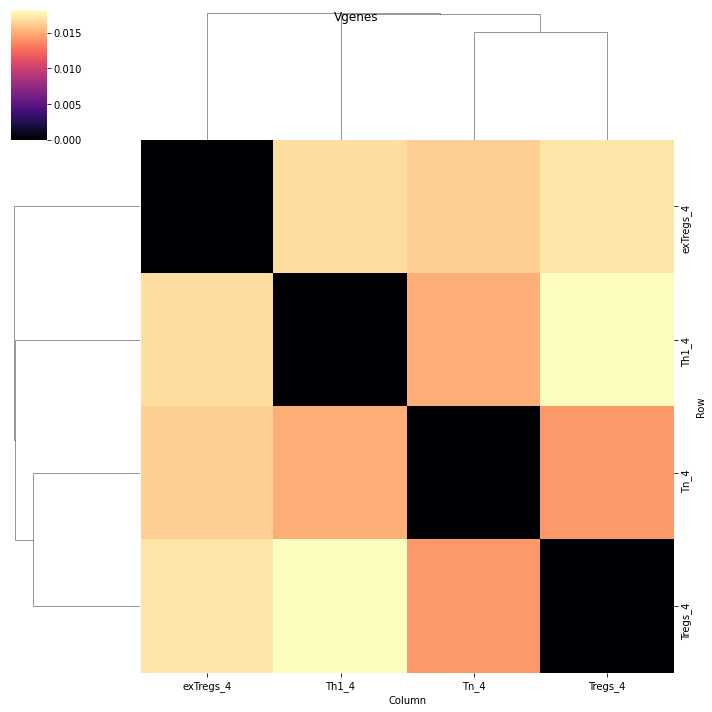

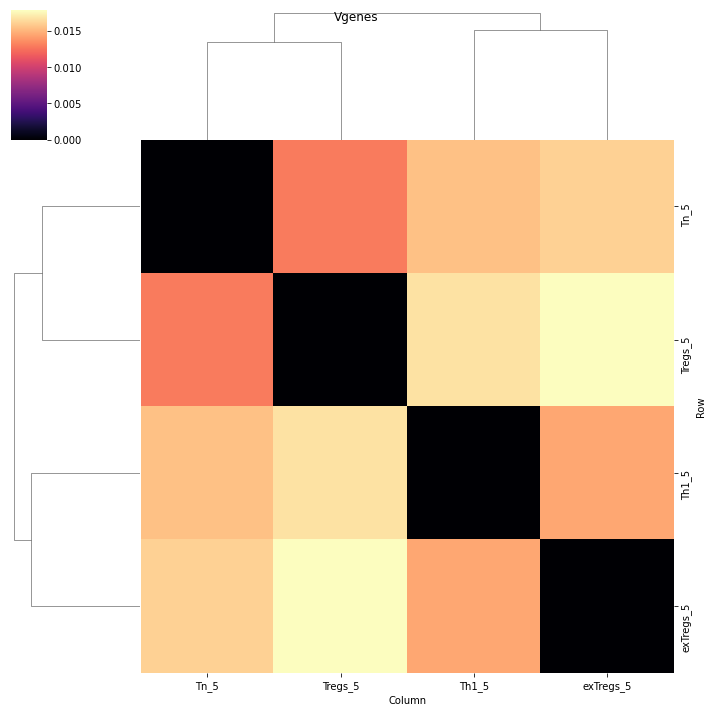

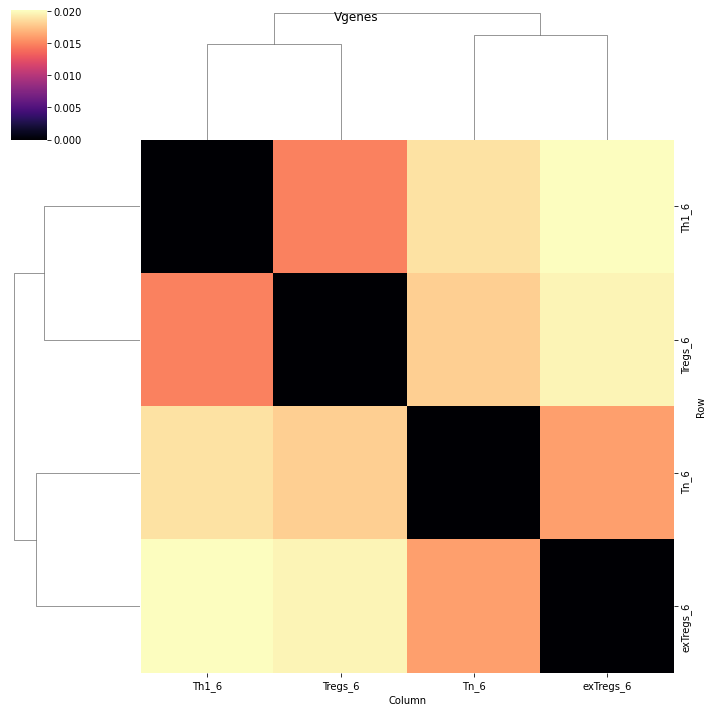

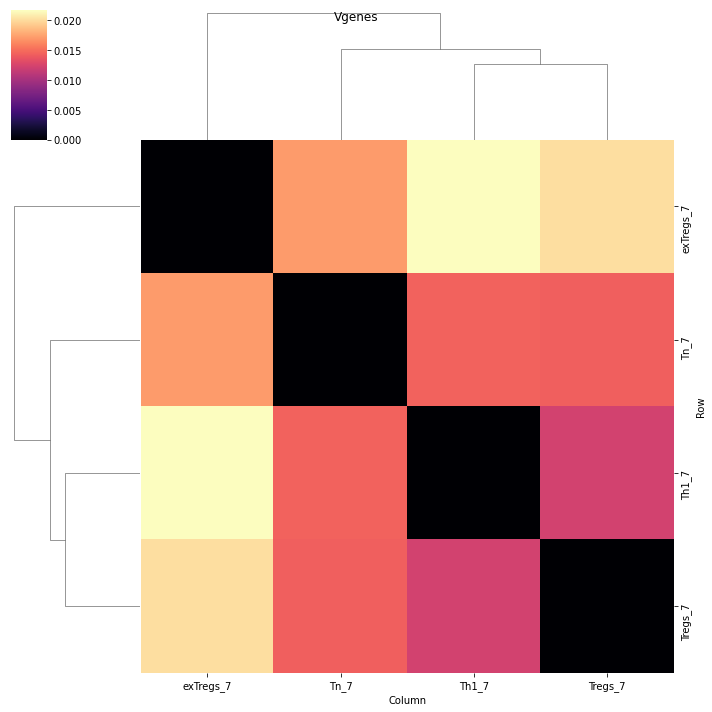

In [ ]:
saveClustermaps(vGenesDonorTypes, 'Vgenes')

In [ ]:
!cp Vgenes_Clustermap_Donor_4.png '/content/drive/MyDrive'
!cp Vgenes_Clustermap_Donor_5.png '/content/drive/MyDrive'
!cp Vgenes_Clustermap_Donor_6.png '/content/drive/MyDrive'
!cp Vgenes_Clustermap_Donor_7.png '/content/drive/MyDrive'

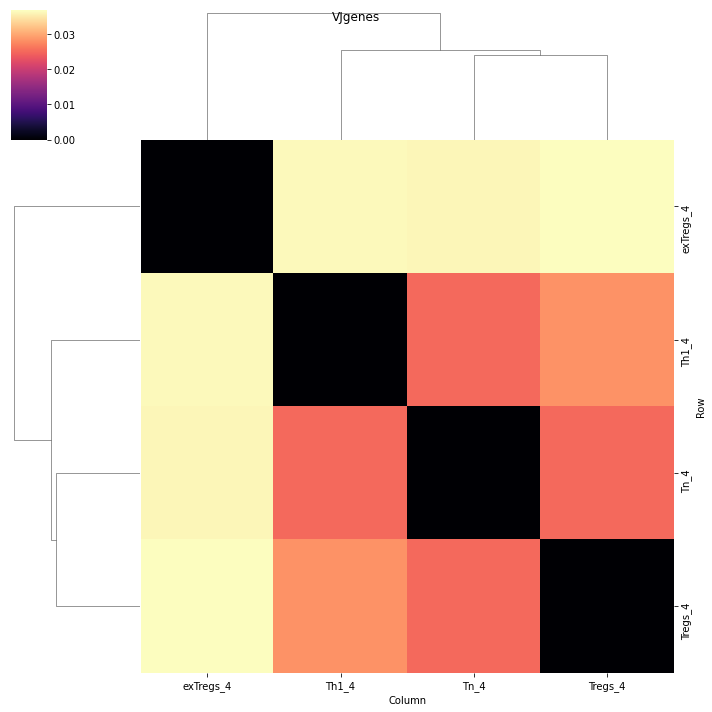

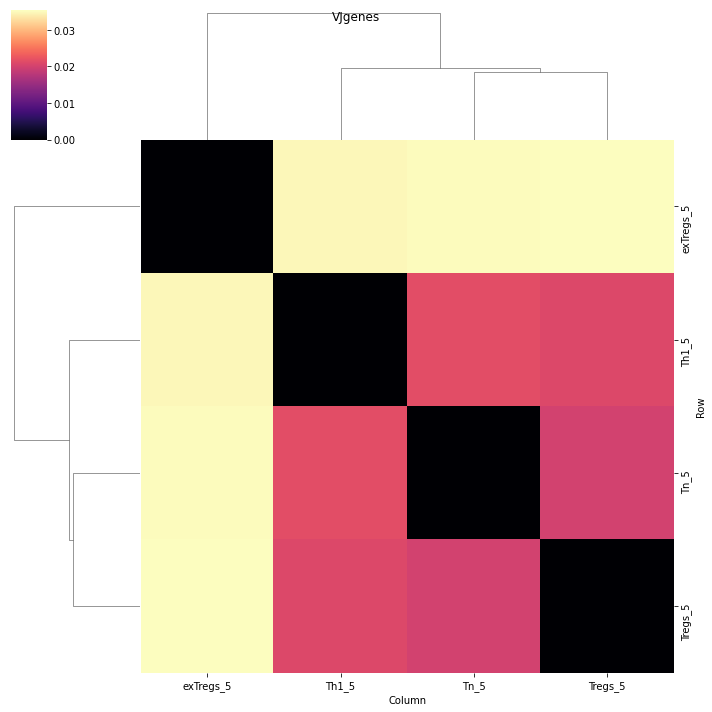

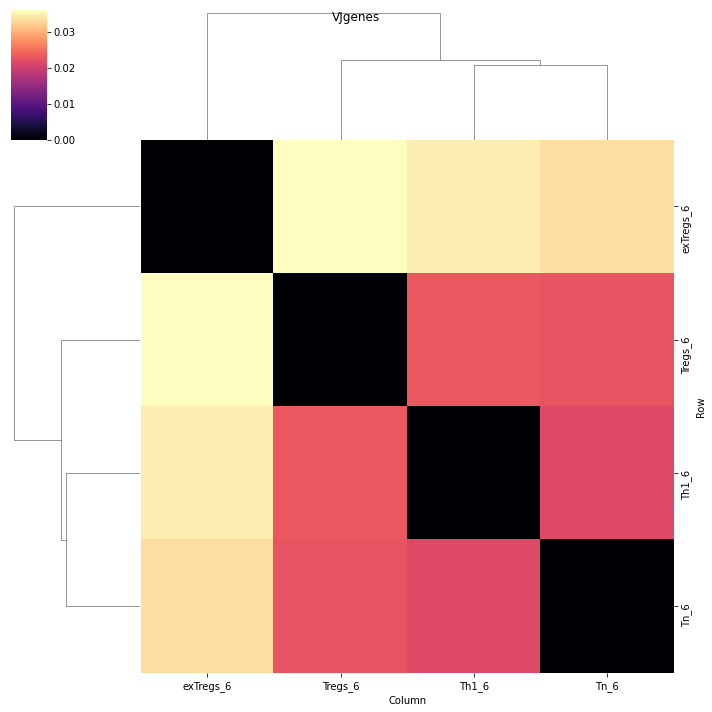

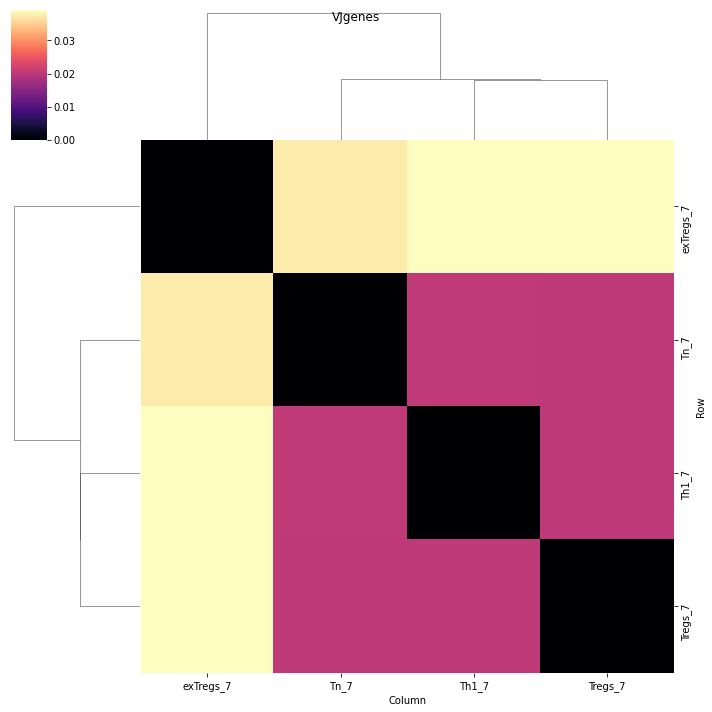

In [ ]:
saveClustermaps(vjGenesDonorTypes, 'VJgenes')

In [ ]:
!cp VJgenes_Clustermap_Donor_4.png '/content/drive/MyDrive'
!cp VJgenes_Clustermap_Donor_5.png '/content/drive/MyDrive'
!cp VJgenes_Clustermap_Donor_6.png '/content/drive/MyDrive'
!cp VJgenes_Clustermap_Donor_7.png '/content/drive/MyDrive'

# Write Donor/Cell Type Comparisons to File

In [ ]:
vDonorDistance

In [ ]:
vjDonorDistance.to_csv("vjDonorDistance.csv")
vDonorDistance.to_csv('vDonorDistance.csv')
!cp vDonorDistance.csv '/content/drive/MyDrive'
!cp vjDonorDistance.csv '/content/drive/MyDrive'